## RG distribution between Prod and Development
---

Dan asked about the score distribution between the production and development. Let's find out about the reason.

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [131]:
# load dev data
dev_df = pd.read_feather("s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-03/dev_static_20210314.feather")
dev_df = dev_df[dev_df.sample_date == pd.to_datetime("2021-03-14")]
dev_df.shape

(792018, 104)

<AxesSubplot:>

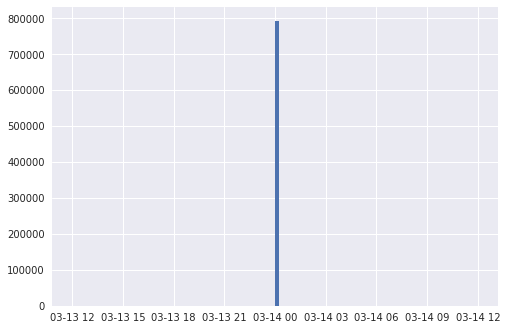

In [132]:
dev_df.sample_date.hist(bins=100)

In [133]:
# load prod data
prod_df = pd.read_parquet("s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-03/prod-data-20210314.parquet")

In [134]:
prod_df.shape, prod_df.party_id.nunique()

((953371, 56), 947268)

### Get scores and RGs
---

In [135]:
dev_df["age_money_account"] = (
        dev_df["sample_date"] - dev_df["date_account_opened"]
    ).dt.days

dev_df = mu.preprocess(dev_df)

# prev model
prev_model_s3_key = "jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
old_model = mu.read_pickle_from_s3("sofi-data-science", prev_model_s3_key)

dev_df["pred"] = old_model.predict_proba(dev_df[old_model.feature_name_])[:,1]
dev_df["score"] = mu.scale_scores(dev_df["pred"])

In [136]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

dev_df["risk_group"] = get_risk_groups(dev_df["score"])
prod_df["risk_group"] = get_risk_groups(prod_df["model_score"])

<AxesSubplot:>

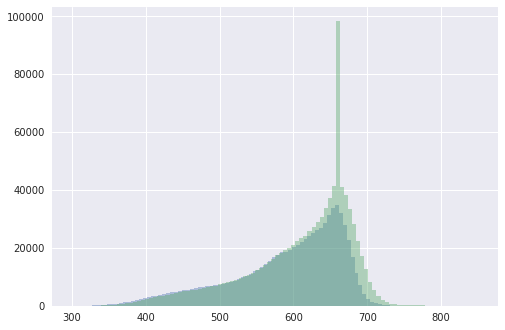

In [137]:
dev_df.score.hist(bins=100, alpha=0.4)
prod_df.model_score.hist(bins=100, alpha=0.4)

<AxesSubplot:>

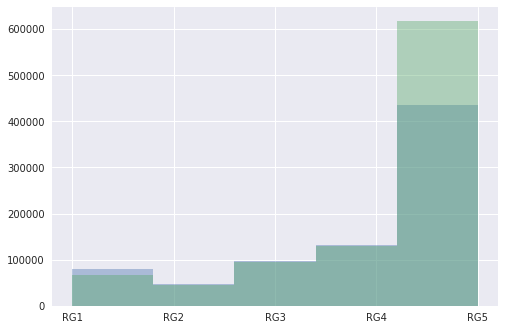

In [138]:
dev_df.risk_group.hist(bins=5, alpha=0.4)
prod_df.risk_group.hist(bins=5, alpha=0.4)

### On ids that aligns

In [139]:
shared_ids = set(dev_df.user_id.unique()).intersection(set(prod_df.party_id.unique()))
len(shared_ids)

789905

In [140]:
dev_df_ = dev_df[dev_df.user_id.isin(shared_ids)].drop_duplicates(subset="user_id")
prod_df_ = prod_df[prod_df.party_id.isin(shared_ids)].drop_duplicates(subset="party_id")

<AxesSubplot:>

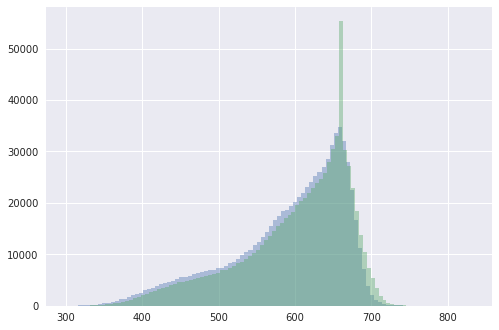

In [141]:
dev_df_.score.hist(bins=100, alpha=0.4)
prod_df_.model_score.hist(bins=100, alpha=0.4)

<AxesSubplot:>

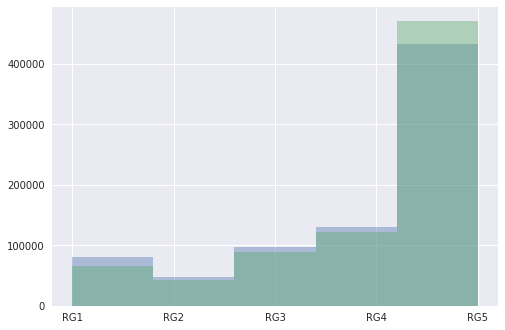

In [142]:
dev_df_.risk_group.hist(bins=5, alpha=0.4)
prod_df_.risk_group.hist(bins=5, alpha=0.4)

<AxesSubplot:>

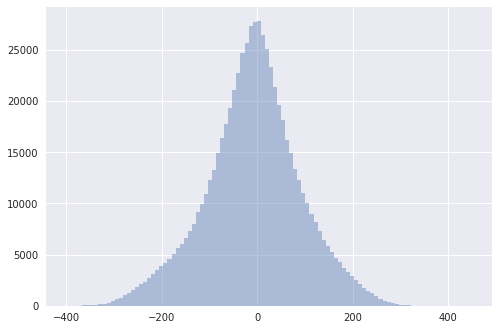

In [143]:
diff = dev_df_.score - prod_df_.model_score
diff.hist(bins=100, alpha=0.4)

In [144]:
dev_df[dev_df.user_id == 15536251][old_model.feature_name_]

,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,phone_risk_score,name_address_correlation,...,nr_trans_ratio,iqt9413,dollar_val_returns_3d,nr_returns_30d,credit_card_loan_amount,fraud_score_1,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
212990,100.0,507.0,NaN,0.322,0.341,0.994,1.10595,124.423962,0.589,0.9096,...,0.264151,1.0,0.0,0.0,242.0,0.082,222,0,-1.0,996.0
212991,-1.0,507.0,NaN,0.322,0.341,0.994,0.00000,0.000000,0.589,0.9096,...,-1.000000,1.0,0.0,0.0,242.0,0.082,222,0,-1.0,996.0
212992,-1.0,507.0,NaN,0.322,0.341,0.994,0.00000,0.000000,0.589,0.9096,...,-1.000000,1.0,0.0,0.0,242.0,0.082,222,0,-1.0,996.0
212993,-1.0,507.0,NaN,0.322,0.341,0.994,0.00000,0.000000,0.589,0.9096,...,-1.000000,1.0,0.0,0.0,242.0,0.082,222,0,-1.0,996.0


In [145]:
prod_df[prod_df.party_id == 15536251][old_model.feature_name_]

,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,phone_risk_score,name_address_correlation,...,nr_trans_ratio,iqt9413,dollar_val_returns_3d,nr_returns_30d,credit_card_loan_amount,fraud_score_1,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
354776,100.0,507.0,NaN,0.322,0.341,0.994,0.0,93.561154,0.589,0.9096,...,0.146341,1.0,0.0,0.0,0.0,0.082,218.0,0,-1.0,996.0


### On RG alignment

In [146]:
dev_df.user_id.nunique(), dev_df.shape

(791937, (792018, 111))

In [147]:
prod_df.party_id.nunique(), prod_df.shape

(947268, (953371, 56))

In [148]:
prod_df.columns

Index(['party_id', 'created_dt', 'updated_dt', 'last_checked_date',
       'last_checked_date_max', 'risk_group', 'request_source', 'model_score',
       'model_decision_rule_details', 'mcustomer_model_risk_groupodel_score',
       'proxy_id', 'risk_group_evaluation_method', 'partner_name',
       'first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score',
       'fraud_score_2', 'name_email_correlation',
       'transaction_as_pct_of_balance', 'mean_account_balance_30d',
       'giact_time_since_last_link', 'phone_risk_score',
       'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction',
       'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions',
       'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
       'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d',
       'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits',
       'bal_ratio', 'name_phone_correlation', 'giact_nr_other',
      

In [149]:
prod_df["risk_group_evaluation_method"].value_counts()

"CUSTOMER_MODEL"    908244
"CLASSIC"            15838
Name: risk_group_evaluation_method, dtype: int64

In [150]:
prod_df["partner_name"].value_counts()

SAMSUNG    523443
SOFI       429928
Name: partner_name, dtype: int64

#### get some ids that is in prod but not in dev

In [151]:
prod_df[~prod_df.party_id.isin(shared_ids)].head()

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,nr_returns_30d,credit_card_loan_amount,fraud_score_1,transaction_code,age_money_account,time_since_last_transaction,nr_trans_ratio,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
6,14661,2020-09-02 05:11:22.961,2021-02-03 03:05:21.023,2021-01-27 03:15:39.736,2021-01-27 03:15:39.736,RG5,"""scheduled""",659.267777,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,0.0,NaN,NaN,NONE,NaN,-1.0,-1.0,0,-1.0,-1.0
36,220524,2020-10-14 02:57:54.399,2020-11-04 03:27:24.346,2020-10-28 02:52:41.655,2020-10-28 02:52:41.655,RG2,"""scheduled""",490.161965,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG2B""",...,0.0,46964.0,0.0148,NONE,363.0,-1.0,-1.0,0,-1.0,-1.0
59,420124,2020-09-11 12:44:46.871,2020-09-30 02:45:42.659,2020-09-11 12:44:46.862,2020-09-11 12:44:46.862,RG5,"""onboarding""",630.345186,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,0.0,NaN,NaN,None,NaN,-1.0,-1.0,0,-1.0,-1.0
63,464171,2020-10-14 02:03:03.532,2021-03-10 03:45:26.502,2021-03-10 03:45:26.501,2021-03-10 03:45:26.501,RG5,"""scheduled""",659.267777,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG4A""",...,0.0,NaN,NaN,NONE,NaN,-1.0,-1.0,0,-1.0,-1.0
64,478086,2020-12-09 03:15:21.846,2021-03-10 03:21:48.001,2021-03-10 03:21:48.000,2021-03-10 03:21:48.000,RG2,"""scheduled""",499.939469,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,0.0,29198.0,0.0176,ACHDWIN,343.0,1.0,0.0,3,-1.0,-1.0


In [173]:
acct_data = pd.read_feather("../../data/processed/processed_1615685210/banking_accounts_1615685210.feather")

In [174]:
acct_data.user_id.nunique()

878902

In [175]:
missing_accts = acct_data[~acct_data.user_id.isin(shared_ids)]

In [203]:
prod_accts_only = set(prod_df.party_id) - shared_ids

In [176]:
missing_accts.head()

,user_id,business_account_number,date_account_opened,date_account_closed,account_type,account_closed_reason,joint_user_id,account_age_days_asof_pull
7,378,410002894815,2019-10-07,2020-09-25,410,Customer Request,NaN,523
8,402,410000091385,2018-07-06,2021-01-03,410,Customer Request,NaN,981
36,1502,410003991731,2020-01-03,2020-03-01,410,Opened in Error,NaN,435
42,1794,410002392579,2019-08-13,2020-09-15,410,Customer Request,14378981.0,578
43,1853,410000095337,2018-07-12,2019-06-24,410,Closed by SoFi - Risk Request,NaN,975


In [177]:
missing_accts.date_account_closed.isna().value_counts()

False    80684
True     15105
Name: date_account_closed, dtype: int64

In [178]:
missing_accts.account_closed_reason.isna().value_counts()

False    57420
True     38369
Name: account_closed_reason, dtype: int64

#### Reason 1: Joint Acconts - lost in the middle of modeling

In [179]:
missing_accts[missing_accts.user_id == 14378981.0]

,user_id,business_account_number,date_account_opened,date_account_closed,account_type,account_closed_reason,joint_user_id,account_age_days_asof_pull
189810,14378981,410002392579,2019-08-13,2020-09-15,410,Customer Request,1794.0,578


In [180]:
missing_accts[missing_accts.business_account_number==410002392579]

,user_id,business_account_number,date_account_opened,date_account_closed,account_type,account_closed_reason,joint_user_id,account_age_days_asof_pull
42,1794,410002392579,2019-08-13,2020-09-15,410,Customer Request,14378981.0,578
189810,14378981,410002392579,2019-08-13,2020-09-15,410,Customer Request,1794.0,578


In [181]:
prod_df[prod_df.party_id.isin([1794, 14378981])]

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,nr_returns_30d,credit_card_loan_amount,fraud_score_1,transaction_code,age_money_account,time_since_last_transaction,nr_trans_ratio,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
53366,1794,2020-08-05 06:36:27.163,2020-09-30 02:25:21.647,2020-09-02 05:37:10.337,2020-09-02 05:37:10.337,RG1,"""scheduled""",467.493303,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,0.0,NaN,NaN,None,NaN,-1.0,-1.0,0,-1.0,-1.0
142471,14378981,2020-08-05 06:22:53.094,2020-09-30 02:31:28.529,2020-09-02 05:44:33.783,2020-09-02 05:44:33.783,RG2,"""scheduled""",510.366157,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG2""",...,0.0,NaN,NaN,None,NaN,-1.0,-1.0,0,-1.0,-1.0


### Reason 2: 410000524069

In [ ]:
df_labeled = pd.read_feather("../../data/labeled/labeled_1618211092.feather")

In [204]:
list(prod_accts_only)[:5]

[16777221, 16777225, 16777232, 18350097, 17825812]

In [211]:
acct_data[acct_data.user_id==17825812]

,user_id,business_account_number,date_account_opened,date_account_closed,account_type,account_closed_reason,joint_user_id,account_age_days_asof_pull


In [219]:
prod_df[prod_df.party_id == 17825812][["model_decision_rule_details", 
                                       "request_source", 
                                       "risk_group_evaluation_method"]]

,model_decision_rule_details,request_source,risk_group_evaluation_method
857574,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""onboarding""","""CUSTOMER_MODEL"""


In [218]:
prod_df[prod_df.party_id == 17825812][["model_decision_rule_details"]].values

array([['[{"ruleName":"isMember","rulePassed":false,"riskGroupCode":"RG1"},{"ruleName":"noRecentAch","rulePassed":true,"riskGroupCode":"RG1"},{"ruleName":"notHighRisk","rulePassed":true,"riskGroupCode":"RG1"},{"ruleName":"allPass","rulePassed":false,"riskGroupCode":"RG1"}]']],
      dtype=object)

In [220]:
prod_df[prod_df.party_id == 17825812].T

,857574
party_id,17825812
created_dt,2021-01-24 17:23:57.255
updated_dt,2021-01-27 04:21:48.683
last_checked_date,2021-01-24 17:24:03.895
last_checked_date_max,2021-01-24 17:24:03.895
risk_group,RG5
request_source,"""onboarding"""
model_score,610.665384
model_decision_rule_details,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri..."
mcustomer_model_risk_groupodel_score,"""RG5"""


In [194]:
missing_accts.business_account_number.value_counts()

410007072688    2
410002678838    2
410002194865    2
410002024638    2
410001907012    2
               ..
410000524069    1
410004469090    1
410001208107    1
410000673580    1
410007296372    1
Name: business_account_number, Length: 95088, dtype: int64

In [195]:
bid = 410001208107
missing_accts[missing_accts.business_account_number==bid]

,user_id,business_account_number,date_account_opened,date_account_closed,account_type,account_closed_reason,joint_user_id,account_age_days_asof_pull
123573,13436732,410001208107,2019-03-20,2019-04-05,410,None,NaN,724


In [196]:
dev_df[dev_df.business_account_number==bid]

,user_id,business_account_number,date_account_opened,date_account_closed,account_type,account_closed_reason,joint_user_id,account_age_days_asof_pull,sample_date,borrower_id,...,target,target_with_restriction,indeterminate,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,pred,score,risk_group


In [199]:
df_labeled[df_labeled.business_account_number==bid]

,user_id,business_account_number,date_account_opened,date_account_closed,account_type,account_closed_reason,joint_user_id,account_age_days_asof_pull,sample_date,borrower_id,...,lag_acc_open_first_transaction,first_deposit_amount,dollar_val_returns,is_chg_wrt_off_in_90d,days_to_acc_close,account_closed_by_risk_in_next_90d,last_unrestricted_date_in_next_90d,target,target_with_restriction,indeterminate


In [202]:
prod_df[prod_df.party_id==13436732]

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,nr_returns_30d,credit_card_loan_amount,fraud_score_1,transaction_code,age_money_account,time_since_last_transaction,nr_trans_ratio,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded


In [200]:
df_labeled.user_id.nunique()

831713

In [189]:
df_labeled.sample_date.max()

Timestamp('2021-03-12 00:00:00')

In [190]:
prod_df.head()

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,nr_returns_30d,credit_card_loan_amount,fraud_score_1,transaction_code,age_money_account,time_since_last_transaction,nr_trans_ratio,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
0,2632,2020-08-05 06:24:00.930,2021-03-10 03:15:37.339,2021-03-10 03:15:37.336,2021-03-10 03:15:37.336,RG1,"""scheduled""",456.953203,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,0.0,7826.0,0.3952,NONE,460.0,-1.0,-1.000000,0,-1.0,-1.0
1,2950,2020-10-14 03:22:37.349,2021-03-10 03:18:16.453,2021-03-10 03:18:16.452,2021-03-10 03:18:16.452,RG1,"""scheduled""",472.210392,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,0.0,38308.0,0.0243,NONE,334.0,-1.0,-1.000000,0,-1.0,-1.0
2,4504,2020-10-14 02:13:38.249,2021-03-10 03:08:09.948,2021-03-10 03:08:09.947,2021-03-10 03:08:09.947,RG5,"""scheduled""",659.267777,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG4A""",...,0.0,NaN,NaN,NONE,NaN,-1.0,-1.000000,0,-1.0,-1.0
3,8307,2020-08-05 06:14:24.194,2021-03-10 03:01:39.552,2021-03-10 03:01:39.550,2021-03-10 03:01:39.550,RG1,"""scheduled""",421.178832,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,0.0,70894.0,0.0144,POSDW,646.0,0.0,0.000000,1,-1.0,-1.0
4,10099,2020-08-05 06:42:27.521,2021-03-10 03:18:09.639,2021-03-10 03:18:09.638,2021-03-10 03:18:09.638,RG1,"""scheduled""",384.257334,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,0.0,29540.0,0.0326,POSDW,545.0,0.0,0.089744,1,-1.0,-1.0


In [191]:
prod_df.created_dt.max()

'2021-03-14 04:10:06.311'

In [192]:
prod_df.updated_dt.fillna("").max()

'2021-03-14 04:07:11.069'